[ 806.0192303  856.7279216  904.3990162  952.5619108 1026.5589858
 1059.3413715]
0.5098064314260926
[0.46530179 0.39986412 0.35955622 0.282425   0.15347284 0.06272757]
73438.86768539019
9.222492655193335


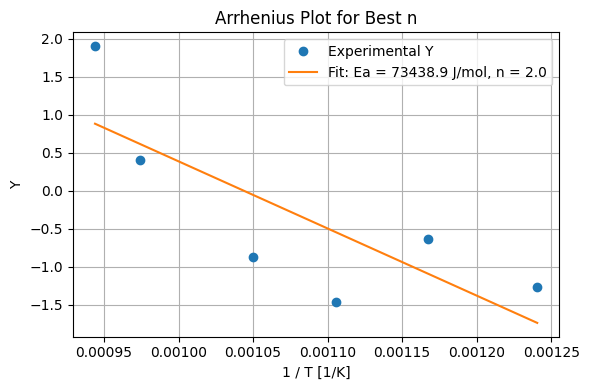

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

'''Still need to adjust the S_V calculation'''

# === INPUT DATA ===
dP_CH4 = 0.0001

#data organization
tempss = np.array([532.8692303, 583.5779216, 631.2490162, 679.4119108, 753.4089858, 786.1913715])  # °C
T_data = tempss + 273.15  # K
print(T_data)

V_R = 2343.7 * 10**-9  # Reactor volume in m^3
R = 8.314  # J/mol*K

ch4_ss = np.array([10.58967786, 9.100399715, 8.183042916, 6.427634432, 3.492847043, 1.427599783])
h2_ss = np.array([19.61424661, 24.35439391, 33.08009652, 40.18316061, 49.97503291, 56.3472753])
co_ss = np.array([0.0001429849477, 0.001020061582, 2.582607912, 4.370178284, 7.305258501, 9.710402925])
co2_ss = np.array([1.564520092, 2.374852411, 3.220787043, 3.444686712, 3.329101979, 2.928459987])
h2o_ss = np.array([47.61807528, 45.04543954, 34.72758843, 29.1242299 , 22.38286837, 18.13688983])

# System pressure
P_sys = 3.15 # bar

#inlet SCCM
SCCM_CH4_feed = 16.16
SCCM_H2_feed = 9
SCCM_CO_feed = 0
SCCM_CO2_feed = 0
SCCM_H20_feed = 43.04
SCCM_Ar_feed = 3.49
total_flow = (SCCM_CH4_feed + SCCM_H2_feed + SCCM_CO_feed + SCCM_CO2_feed + SCCM_H20_feed + SCCM_Ar_feed)/60000000 #m^3/s
TotalSCCM = SCCM_CH4_feed + SCCM_H2_feed + SCCM_CO_feed + SCCM_CO2_feed + SCCM_H20_feed + SCCM_Ar_feed

P_CH4_in = P_sys * SCCM_CH4_feed/TotalSCCM
P_H2_in = P_sys * SCCM_H2_feed/TotalSCCM
P_CO_in = P_sys * SCCM_CO_feed/TotalSCCM
P_CO2_in = 0
P_H2O_in = P_sys * SCCM_H20_feed/TotalSCCM
P_Ar_in = P_sys * SCCM_Ar_feed/TotalSCCM

S_V = total_flow/V_R # s^-1 DO THIS BASED ON THE INLET
print(S_V)

# Partial pressures (outlet)
ch4_p = P_sys * (ch4_ss / TotalSCCM)  # bar
h2o_p = P_sys * (h2o_ss / TotalSCCM)  # bar
co_p = P_sys * (co_ss / TotalSCCM)  # bar
co2_p = P_sys * (co2_ss / TotalSCCM)  # bar
h2o_p = P_sys * (h2o_ss / TotalSCCM)  # bar

print(ch4_p)

# === EQUILIBRIUM CONSTANT FUNCTION ===
def K_eq(T):
    return (101325/100000)**2 * np.exp(-26830/T + 30.114) # bar^2

# === INTEGRAL FUNCTION ===
def integral_I(n, T, P_CH4_out):
    sum = 0
    #adjust these to get the data when you are done
    P_CH4 = P_CH4_in
    P_H2O = P_H2O_in
    P_H2 = P_H2_in
    P_CO = 0

    while P_CH4 > P_CH4_out:
        denom = (P_CH4**n) * (P_H2O**n) - 1/(K_eq(T)**n) * (P_CO**n) * (P_H2**(3*n))
        add = dP_CH4/denom
        if denom <= 0 or np.isnan(denom) or np.isinf(denom):
                add = 0
        sum = sum + add
        P_CH4 = P_CH4 - dP_CH4
        P_H2O = P_H2O - dP_CH4
        P_H2 = P_H2 + 3*dP_CH4
        P_CO = P_CO + dP_CH4

        #pressure normalization
        Ptotnew = P_CH4 + P_H2O + P_H2 + P_CO + P_Ar_in
        P_CH4 = P_CH4*P_sys/Ptotnew
        P_H2O = P_H2O*P_sys/Ptotnew
        P_H2 = P_H2*P_sys/Ptotnew
        P_CO = P_CO*P_sys/Ptotnew
    return sum

# === SCAN n VALUES AND FIT ===
n_range = np.linspace(0.5, 2.0, 50) #[1.1, 1.1]
results = []

for n in n_range:
    I_n = np.array([integral_I(n, T, P_CH4_out) for T, P_CH4_out in zip(T_data, ch4_p)])
    expY = (S_V * I_n)
    Y = np.log(expY)
    inv_T = 1 / T_data
    slope, intercept, r_value, _, _ = linregress(inv_T, Y)
    Ea = -slope * R
    results.append({
        'n': n,
        'Ea_Jmol': Ea,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2
    })

# === SELECT BEST n ===
best_result = max(results, key=lambda d: d['r_squared'])
best_n = best_result['n']
best_slope = best_result['slope']
best_intercept = best_result['intercept']
best_Ea = best_result['Ea_Jmol']
print(best_Ea)
print(best_intercept)

# === PLOT BEST FIT ===
I_best = np.array([integral_I(best_n, T, P_CH4_out) for T, P_CH4_out in zip(T_data, ch4_p)])
expY_best = (S_V * I_best)
Y_best = np.log(expY_best)
inv_T = 1 / T_data
Y_fit = best_slope * inv_T + best_intercept

plt.figure(figsize=(6, 4))
plt.plot(inv_T, Y_best, 'o', label='Experimental Y')
plt.plot(inv_T, Y_fit, '-', label=f'Fit: Ea = {best_Ea:.1f} J/mol, n = {best_n}')
plt.xlabel('1 / T [1/K]')
plt.ylabel('Y')
plt.title('Arrhenius Plot for Best n')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()